# Naive Bayes

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import CategoricalNB
from sklearn import preprocessing


df = pd.read_csv('breast-cancer.data', 
                 header = None, 
                 names= ["class", "age", "menopause", "tumor-size", "inv-nodes",
                         "node-caps", "deg-malig", "breast", "breast-quad", " irradiat"])
# Create id column
df['id'] = pd.Series([i +1 for i in range(len(df))])
df.set_index('id')

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
id,,,,,,,,,,
1,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
3,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
4,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
5,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
282,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
283,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
284,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no


Because the clasifier has problems when certain groups are very small,  we have to check how are each level of the variables distributed between the two levels of the variable `class`. If certain groups are very small, the classifier would work better by grouping small groups into bigger groups.

In [8]:
print(pd.crosstab(df['age'], df['class']), "\n")
print(pd.crosstab(df['menopause'], df['class']), "\n")
print(pd.crosstab(df['tumor-size'], df['class']), "\n")
print(pd.crosstab(df['inv-nodes'], df['class']), "\n")
print(pd.crosstab(df['node-caps'], df['class']), "\n")

class  no-recurrence-events  recurrence-events
age                                           
20-29                     1                  0
30-39                    21                 15
40-49                    63                 27
50-59                    71                 25
60-69                    40                 17
70-79                     5                  1 

class      no-recurrence-events  recurrence-events
menopause                                         
ge40                         94                 35
lt40                          5                  2
premeno                     102                 48 

class       no-recurrence-events  recurrence-events
tumor-size                                         
0-4                            7                  1
10-14                         27                  1
15-19                         23                  7
20-24                         34                 16
25-29                         36                 18
3

I will merge the variables where there is very few data points so the classifier does not have any problems.

In [9]:
def tumor_merge(row):
  '''
  Reclassify the tumor variable to have bigger groups
  '''
  if row == "5-9" or row == "0-4":
    return "0-9"
  elif row == "50-54" or row == "45-49":
    return "45-54"
  else:
    return row

def nodes_merge(row):
  '''
  Reclassify the inv-nodes variable to have bigger groups
  '''
  if row == "9-11" or row == "12-14" or row == "15-17" or row =="24-26":
    return "=> 9"
  else:
    return row

def age_merge(row):
  '''
  Merge age groups so each group is bigger 
  '''
  if row == "20-29" or row == "30-39":
    return "20-39"
  elif row == "60-69" or row == "70-79":
    return "60-79"
  else:
    return row

def meno_merge(row):
  '''
  Group together lt40 and ge40 to create bigger groups
  '''
  if row == "lt40" or row == "ge40":
    return "ge40"
  else:
    return "premeno"

# Filter out the 8 rows that have "?" in node-caps
df = df[df["node-caps"] != "?"]

# Apply the functions to the data frame
df.loc[:,"age"] = df["age"].apply(lambda x: age_merge(x))
df.loc[:,"inv-nodes"] = df["inv-nodes"].apply(lambda x: nodes_merge(x))
df.loc[:,"tumor-size"] = df["tumor-size"].apply(lambda x: tumor_merge(x))
df.loc[:,"menopause"] = df["menopause"].apply(lambda x: meno_merge(x))

This is how the distribution of the groups looks like after the merge

In [10]:
print(pd.crosstab(df['age'], df['class']), "\n")
print(pd.crosstab(df['menopause'], df['class']), "\n")
print(pd.crosstab(df['tumor-size'], df['class']), "\n")
print(pd.crosstab(df['inv-nodes'], df['class']), "\n")
print(pd.crosstab(df['node-caps'], df['class']), "\n")

class  no-recurrence-events  recurrence-events
age                                           
20-39                    22                 15
40-49                    62                 27
50-59                    69                 23
60-79                    43                 17 

class      no-recurrence-events  recurrence-events
menopause                                         
ge40                         95                 34
premeno                     101                 48 

class       no-recurrence-events  recurrence-events
tumor-size                                         
0-9                           11                  1
10-14                         27                  1
15-19                         23                  6
20-24                         34                 14
25-29                         33                 18
30-34                         33                 25
35-39                         12                  7
40-44                         16          

### Define Split data function

Here I write by hand a very simple data split function. It takes a dataframe, and the relative size of the test data frame desired, and returns the train and the test dataframes.

In [11]:
def split_df(df, test_size):
  '''
  This function takes a data frame, and a number from 0 to 1 that represents the
  size of the test data relative to the original dataframe.
  '''
  test = df.sample(frac = test_size, replace = False)
  train = df.copy()
  for index in test.id:
    if index in train.id:
      train = train.drop([index])
  return test, train

# Define Naive Bayes functions

For each combination of attributes $x_{i}$, we will apply Bayes rule to estimate the probability of recurrence events.

$$P(RE|\{x_{1}, .., x_{n}\}) = \frac{P(\{x_{1}, .., x_{n}\}|RE)P(RE)}{P(\{x_{1}, .., x_{n}\})}$$

Because of the assumption of independence, we can translate this into:

$$P(RE|\{x_{1}, .., x_{n}\}) \propto Π_{i \in cols}^{}(\{x_{1}, .., x_{n}\}|RE)P(RE)$$

which means that the posterior probability of having reccuring events, conditional on the values of each variable $x_{i}$
 should be proportional to the likelihood times the posterior.

This value is then normilized by dividing this by

$$Π_{i \in cols}^{}P(\{x_{1}, .., x_{n}|RE) +  P(\{x_{1}, .., x_{n}|no-RE)$$


In [12]:
def get_cond_prob(df, condition):
  '''
  This will calculate the conditional probabilities for each column.
  Conditional on class 
  '''
  conditional_df = df[df['class'] == condition]
  base_rate = len(conditional_df)
  probs_dict = {}
  for col in df.columns[1:-1]:
    summary = df[['id', col, 'class']].groupby([col, 'class']).count()
    summary[summary.index.get_level_values("class") == condition] #because summary returns a multiindex data frame
    # Convert this into conditional probabilities
    summary = summary.id/base_rate
    #Add this to the dicitonary
    probs_dict[col] = summary.to_dict()
  return probs_dict, base_rate/len(conditional_df)

def NaiveBayes(train, test):
  '''
  This function calculates de probability that certain row survived,
  given all the information in the data.
  '''
  cond_prob_rec, pc = get_cond_prob(train, 'recurrence-events')
  cond_prob_norec, pnorec = get_cond_prob(train, 'no-recurrence-events')
 
  preds = []
  for i in range(len(test)):
    row = test.iloc[i]
    prob1 = 1
    prob2 = 1
    # For each column, get in the table the conditional and unconditional probabilities and multiply it 
    for col in ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', ' irradiat']:
      ## Apply the probabilities I got previously to the test df
      try:
        prob1 = cond_prob_rec[col][(row[col], "recurrence-events")] * prob1
        prob2 = cond_prob_norec[col][row[col], "no-recurrence-events"]*prob2
      except KeyError:
        print(f"This key {row[col]} was a key not found")
       #print(f'attr_cond_probabilities[col]: {cond_prob_rec[col]}')
        
    preds.append(prob1*pc/(prob1 + prob2))
  return preds

# 1. Split the data

In [13]:
test, train = split_df(df, 0.2)

# 2. Apply classifier to test data

In [14]:
predictions = NaiveBayes(train, test)

## ROC curve

First, I have to transform the variables so that sklearn classifier can fit the data

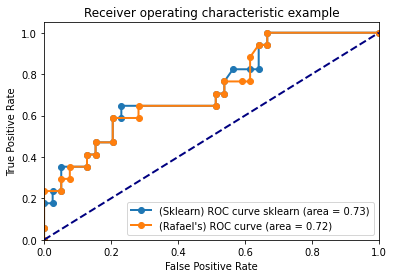

In [15]:
# for sklearn to work, I have to first transform all the variables into number
le = preprocessing.LabelEncoder()

train = train.apply(lambda x: le.fit_transform(x))
train = train.drop(["id"], axis = 1)

test = test.apply(lambda x: le.fit_transform(x))
test = test.drop(["id"], axis = 1)

# Create the data that I will feed sklearn
Y = train['class']
X = train.drop(["class"], axis = 1)
clf = CategoricalNB()
clf.fit(X,Y)

X_pred = test.drop(["class"], axis = 1)
Y_pred = test['class']
#Predict the values for the test data and get the auc, false positive rate, and true positive rate for the sklearn preductions
probs = clf.predict_proba(X_pred)[:,1]
fpr, tpr, threshs = roc_curve(Y_pred, probs)
roc_auc = auc(fpr, tpr)

# Get the same values as above, but for the predictions of my algorithm
fpr2, tpr2, threshs2 = roc_curve(Y_pred, predictions)
roc_auc2 = auc(fpr2, tpr2)

#Plot the ROC curve 
plt.plot(
    fpr,
    tpr,
    'o-',
    lw=2,
    label="(Sklearn) ROC curve sklearn (area = %0.2f)" % roc_auc,   
)
plt.plot(
    fpr2,
    tpr2,
    'o-',
    lw=2,
    label="(Rafael's) ROC curve (area = %0.2f)" % roc_auc2,   
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

Conclusion:

My classifier is very close to the sklearn one. Sometimes it is a bit better, and cometimes a big worse, but the AOC of both classifiers is usually very close